In [1]:
import os
import sys
from pathlib import Path

REPO_URL = "https://github.com/ChangeEngine/Intro-to-ML--Group-1--Final-Project.git"
REPO_DIR = Path("/content/Intro-to-ML--Group-1--Final-Project")

if "google.colab" in sys.modules:
    if not REPO_DIR.exists():
        !git clone $REPO_URL $REPO_DIR
    os.chdir(REPO_DIR)

print("Working directory:", Path.cwd())


Cloning into '/content/Intro-to-ML--Group-1--Final-Project'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 175 (delta 66), reused 9 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 12.97 MiB | 11.06 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Working directory: /content/Intro-to-ML--Group-1--Final-Project


In [2]:
from pathlib import Path

DATA_DIR = Path("data")
if not DATA_DIR.exists():
    alt = Path("..") / "data"
    if alt.exists():
        DATA_DIR = alt
    else:
        raise FileNotFoundError(
            "Could not find data/ at ./data or ../data. "
                    )

print("Using data folder:", DATA_DIR.resolve())
print("Files in data/:")
for p in DATA_DIR.iterdir():
    print(" -", p.name)

Using data folder: /content/Intro-to-ML--Group-1--Final-Project/data
Files in data/:
 - t10k-images.idx3-ubyte.gz
 - t10k-labels.idx1-ubyte.gz
 - train-labels.idx1-ubyte.gz
 - train-images.idx3-ubyte.gz


In [3]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

plt.rcParams["figure.figsize"] = (4, 4)


In [4]:
def load_mnist_images(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:16], dtype=">i4")
    magic, num_images, rows, cols = header
    assert magic == 2051, "Not an images file"

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)
    return images


def load_mnist_labels(path):
    with gzip.open(path, "rb") as f:
        data = f.read()

    header = np.frombuffer(data[:8], dtype=">i4")
    magic, num_labels = header
    assert magic == 2049, "Not a labels file"

    labels = np.frombuffer(data[8:], dtype=np.uint8)
    return labels


def load_mnist_dataset(images_path, labels_path, normalize=True):
    X = load_mnist_images(images_path)
    y = load_mnist_labels(labels_path)

    if normalize:
        X = X.astype("float32") / 255.0

    return X, y


In [5]:
# Paths to MNIST .gz files
train_images_path = DATA_DIR / "train-images.idx3-ubyte.gz"
train_labels_path = DATA_DIR / "train-labels.idx1-ubyte.gz"
test_images_path  = DATA_DIR / "t10k-images.idx3-ubyte.gz"
test_labels_path  = DATA_DIR / "t10k-labels.idx1-ubyte.gz"

X_train, y_train = load_mnist_dataset(train_images_path, train_labels_path)
X_test, y_test   = load_mnist_dataset(test_images_path, test_labels_path)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_test :", X_test.shape, X_test.dtype)
print("y_test :", y_test.shape, y_test.dtype)

# Flatten 28x28 -> 784 features for MLP
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test), -1)

print("X_train_flat:", X_train_flat.shape)
print("X_test_flat :", X_test_flat.shape)


X_train: (60000, 28, 28) float32
y_train: (60000,) uint8
X_test : (10000, 28, 28) float32
y_test : (10000,) uint8
X_train_flat: (60000, 784)
X_test_flat : (10000, 784)


In [6]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_flat,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train,
)

print("Train subset:", X_tr.shape, y_tr.shape)
print("Val subset  :", X_val.shape, y_val.shape)


Train subset: (48000, 784) (48000,)
Val subset  : (12000, 784) (12000,)


In [7]:
# MLP with GridSearchCV (dense neural network)

mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        activation="relu",
        solver="adam",
        batch_size=128,
        max_iter=20,
        early_stopping=True,
        random_state=42,
    )),
])

param_grid_mlp = {
    "mlp__hidden_layer_sizes": [(128,), (256,)],
    "mlp__alpha": [1e-4, 1e-3],  # L2 regularization
}

# Use a subset of the training split for grid search to keep it fast
X_tr_sub = X_tr[:20000]
y_tr_sub = y_tr[:20000]

grid_mlp = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid_mlp,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

print("Running GridSearchCV for MLP on subset of", X_tr_sub.shape[0], "samples...")
grid_mlp.fit(X_tr_sub, y_tr_sub)
print("Done.")
print("Best params:", grid_mlp.best_params_)
print("Best CV macro F1:", grid_mlp.best_score_)


Running GridSearchCV for MLP on subset of 20000 samples...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Done.
Best params: {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (256,)}
Best CV macro F1: 0.9535036828129612


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
best_mlp = grid_mlp.best_estimator_

# --- Validation performance ---
y_val_pred = best_mlp.predict(X_val)

val_acc = accuracy_score(y_val, y_val_pred)
val_prec_macro, val_rec_macro, val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="macro"
)
val_prec_weighted, val_rec_weighted, val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred, average="weighted"
)

print("VALIDATION RESULTS (MLP)")
print("Accuracy            :", val_acc)
print("Precision (macro)   :", val_prec_macro)
print("Recall (macro)      :", val_rec_macro)
print("F1-score (macro)    :", val_f1_macro)
print("Precision (weighted):", val_prec_weighted)
print("Recall (weighted)   :", val_rec_weighted)
print("F1-score (weighted) :", val_f1_weighted)

# --- Test performance ---
y_test_pred = best_mlp.predict(X_test_flat)

test_acc = accuracy_score(y_test, y_test_pred)
test_prec_macro, test_rec_macro, test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="macro"
)
test_prec_weighted, test_rec_weighted, test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred, average="weighted"
)

print("\nTEST RESULTS (MLP)")
print("Accuracy            :", test_acc)
print("Precision (macro)   :", test_prec_macro)
print("Recall (macro)      :", test_rec_macro)
print("F1-score (macro)    :", test_f1_macro)
print("Precision (weighted):", test_prec_weighted)
print("Recall (weighted)   :", test_rec_weighted)
print("F1-score (weighted) :", test_f1_weighted)

print("\nClassification report (test):\n")
print(classification_report(y_test, y_test_pred))


VALIDATION RESULTS (MLP)
Accuracy            : 0.9653333333333334
Precision (macro)   : 0.9651515519442194
Recall (macro)      : 0.9650054601593092
F1-score (macro)    : 0.9650640995835447
Precision (weighted): 0.9653239601826884
Recall (weighted)   : 0.9653333333333334
F1-score (weighted) : 0.9653141910496172

TEST RESULTS (MLP)
Accuracy            : 0.9642
Precision (macro)   : 0.9639351666140248
Recall (macro)      : 0.9637157508429798
F1-score (macro)    : 0.9637980913592088
Precision (weighted): 0.9641807775732297
Recall (weighted)   : 0.9642
F1-score (weighted) : 0.9641635899775279

Classification report (test):

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.95      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.95      0.96     

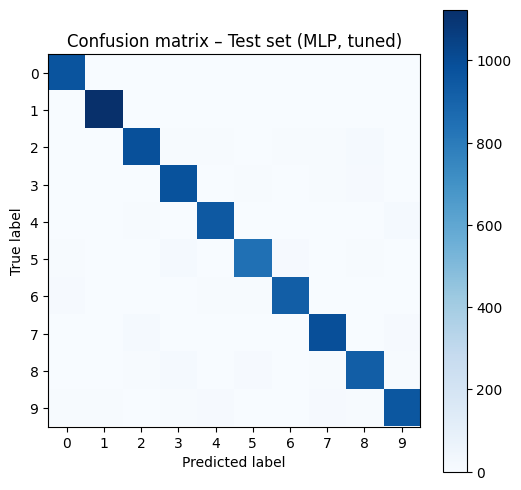

In [9]:
cm_mlp = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 6))
plt.imshow(cm_mlp, cmap="Blues")
plt.title("Confusion matrix – Test set (MLP, tuned)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()


In [10]:
import numpy as np
from collections import Counter

mis_idx = np.where(y_test_pred != y_test)[0]
print("Total test samples:", len(y_test))
print("Total misclassified by MLP:", len(mis_idx))
print("Error rate:", len(mis_idx) / len(y_test))

print("\nMisclassified by true label (how many wrong per digit):")
print(Counter(int(y_test[i]) for i in mis_idx))

Total test samples: 10000
Total misclassified by MLP: 358
Error rate: 0.0358

Misclassified by true label (how many wrong per digit):
Counter({9: 54, 8: 51, 5: 47, 2: 47, 7: 36, 4: 34, 6: 33, 3: 32, 0: 13, 1: 11})


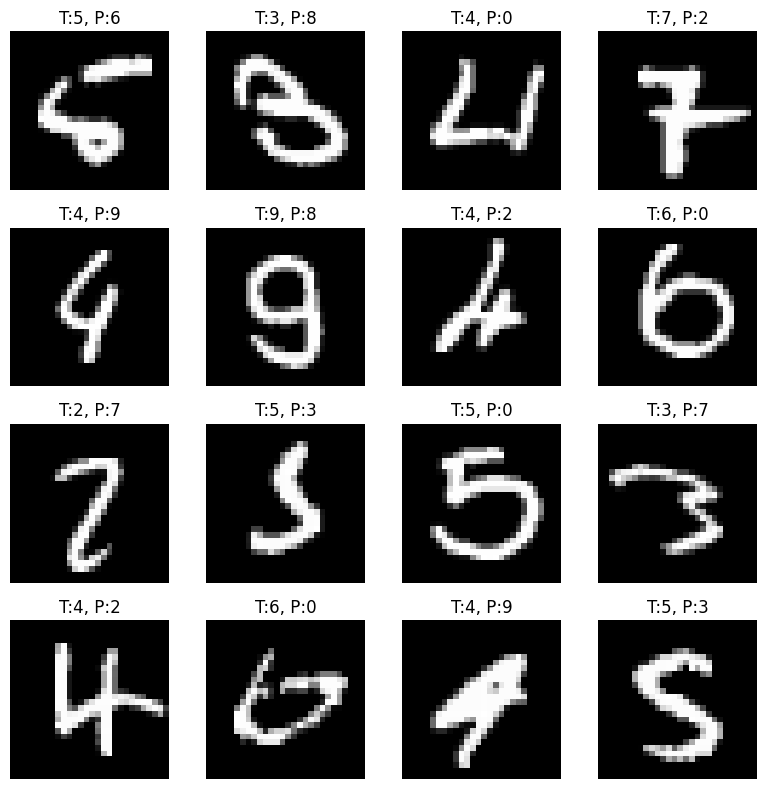

In [11]:
import matplotlib.pyplot as plt

def show_misclassified(images, true_labels, pred_labels, indices, n=16):
    n = min(n, len(indices))
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.axis("off")
        plt.title(f"T:{true_labels[idx]}, P:{pred_labels[idx]}")
    plt.tight_layout()
    plt.show()

show_misclassified(X_test, y_test, y_test_pred, mis_idx, n=16)